In [ ]:
pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Preprocessing Dataset

In [ ]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from transformers import DistilBertTokenizer
import torch

# Load your dataset (replace 'petitions_filtered.csv' with your actual dataset)
df = pd.read_csv('/content/drive/MyDrive/petitions_v2.csv')

# Remove unnecessary columns (assuming 'id' column exists and needs to be removed)
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Define your updated preprocessing function
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers, but add a space instead of removing
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

# Apply preprocessing to the 'action' and 'background' columns
df['action'] = df['action'].apply(preprocess_text)
df['background'] = df['background'].apply(preprocess_text)

# Combine 'action' and 'background' into a single 'text' column
df['text'] = df['action'] + " " + df['background']

# Drop 'action' and 'background' columns
df = df.drop(columns=['action', 'background'])

# Manually map department labels to numeric labels
label_mapping = {
    'Department of Health and Social Care': 0,
    'Department for Education': 1,
    'Department for Transport': 2,
    'Department for Environment, Food and Rural Affairs': 3,
    'Home Office': 4,
    'Cabinet Office': 5,
    'Department for Business, Energy and Industrial Strategy': 6,
    'HM Treasury': 7,
    'Ministry of Justice': 8,
    'Department for Work and Pensions': 9,
    'Department for Levelling Up, Housing and Communities ': 10
}

# Map department labels to numeric labels
df['label'] = df['department'].map(label_mapping)

# Display the first few rows of the preprocessed dataset
print("\nPreprocessed Dataset:")
print(df.head())

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display the shape of the train and test sets
print(f"\nTrain set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


Preprocessed Dataset:
                             department  \
0  Department of Health and Social Care   
1  Department of Health and Social Care   
2  Department of Health and Social Care   
3  Department of Health and Social Care   
4  Department of Health and Social Care   

                                                text  label  
0  hold a public inquiry into pfi and the nhs fin...      0  
1  fund free rape alarms for all the government s...      0  
2  prioritise teachers for covid booster vaccinat...      0  
3  ban advertising campaigns of processed foods t...      0  
4  add crohn s colitis to the medically exempt ce...      0  

Train set shape: (4400, 3)
Test set shape: (1100, 3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# Define the Model

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Define the model class for text classification
class DistilBERTClassifier(nn.Module):
    def __init__(self, distilbert_model, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = distilbert_model
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output[0]  # (batch_size, seq_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # (batch_size, hidden_size)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = torch.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the DistilBERT classifier model
num_classes = len(df['department'].unique())  # Number of unique departments
model = DistilBERTClassifier(distilbert_model, num_classes)
model.to(device)  # Move the model to the GPU if available

# Print the model architecture
print(model)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

# Dataset and Data Loaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset class
class PetitionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LENGTH = 512  # Maximum length of input text
BATCH_SIZE = 16  # Batch size for training and evaluation

# # Create train and test datasets
# train_dataset = PetitionDataset(
#     texts=train_df['text'].tolist(),
#     labels=train_df['label'].tolist(),
#     tokenizer=tokenizer,
#     max_length=MAX_LENGTH
# )

# test_dataset = PetitionDataset(
#     texts=test_df['text'].tolist(),
#     labels=test_df['label'].tolist(),
#     tokenizer=tokenizer,
#     max_length=MAX_LENGTH
# )

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


# Training Parameters

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import torch.nn as nn

# Training parameters
EPOCHS = 3  # Number of training epochs
LEARNING_RATE = 1e-5  # Learning rate

# # Define the optimizer and scheduler
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
# total_steps = len(train_loader) * EPOCHS
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

# # Define the loss function and move it to the appropriate device
# criterion = nn.CrossEntropyLoss().to(device)


# Training and Evaluation Functions

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import time

# Training and evaluation functions
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    # Use tqdm to display a progress bar for training
    with tqdm(total=len(data_loader), desc=f'Training Epoch', unit='batch') as pbar:
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            correct_predictions += torch.sum(torch.argmax(outputs, dim=1) == labels)
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            pbar.update(1)
            pbar.set_postfix({'loss': loss.item()})

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, criterion, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    # Use tqdm to display a progress bar for evaluation
    with tqdm(total=len(data_loader), desc=f'Validation Epoch', unit='batch') as pbar:
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)
                correct_predictions += torch.sum(torch.argmax(outputs, dim=1) == labels)
                losses.append(loss.item())

                pbar.update(1)

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop and Evaluation

In [ ]:
# K-Fold Cross-Validation
def k_fold_cross_validation(model_class, tokenizer, df, label_mapping, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = []
    best_accuracy = 0
    best_model_state = None

    for fold, (train_index, val_index) in enumerate(kf.split(df)):
        print(f'Fold {fold + 1}/{k}')
        print('-' * 10)

        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]

        train_dataset = PetitionDataset(
            texts=train_df['text'].tolist(),
            labels=train_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )

        val_dataset = PetitionDataset(
            texts=val_df['text'].tolist(),
            labels=val_df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=MAX_LENGTH
        )

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        model = model_class(distilbert_model, len(label_mapping))
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        criterion = nn.CrossEntropyLoss().to(device)

        history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
        best_fold_accuracy = 0

        for epoch in range(EPOCHS):
            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_acc, train_loss = train_epoch(
                model,
                train_loader,
                criterion,
                optimizer,
                device,
                scheduler,
                len(train_dataset)
            )

            print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')

            val_acc, val_loss = eval_model(
                model,
                val_loader,
                criterion,
                device,
                len(val_dataset)
            )

            print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')

            history['train_acc'].append(train_acc.item())
            history['train_loss'].append(train_loss)
            history['val_acc'].append(val_acc.item())
            history['val_loss'].append(val_loss)

            # Save the best model for the current fold
            if val_acc > best_fold_accuracy:
                best_fold_accuracy = val_acc
                torch.save(model.state_dict(), f'best_model_state_fold_{fold + 1}.bin')

            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_model_state = model.state_dict()

        results.append(history)

    # Save the overall best model
    if best_model_state:
        torch.save(best_model_state, 'best_model_state.bin')

    return results

# Run K-Fold Cross-Validation
results = k_fold_cross_validation(DistilBERTClassifier, tokenizer, df, label_mapping, k=5)

# Print the results
for i, history in enumerate(results):
    print(f'Results for fold {i + 1}')
    print(f"Train Accuracy: {history['train_acc']}")
    print(f"Train Loss: {history['train_loss']}")
    print(f"Validation Accuracy: {history['val_acc']}")
    print(f"Validation Loss: {history['val_loss']}")

Fold 1/5
----------


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
----------


Training Epoch:   0%|          | 0/275 [00:00<?, ?batch/s]

In [ ]:
Results for fold 1
Train Accuracy: [0.8240162398500936, 0.9188007495315428, 0.9447220487195502]
Train Loss: [0.5780549791091101, 0.27616220468334723, 0.20133354514372764]
Validation Accuracy: [0.877576514678326, 0.8769519050593378, 0.8800749531542785]
Validation Loss: [0.4564700300003042, 0.4528565400713446, 0.4725550474728098]
Results for fold 2
Train Accuracy: [0.9050593379138038, 0.9553404122423484, 0.9701748906933166]
Train Loss: [0.3663902073132427, 0.1741938291191869, 0.12340509807900003]
Validation Accuracy: [0.943785134291068, 0.9406620861961273, 0.9419113054341036]
Validation Loss: [0.19850012221106209, 0.21427290399770926, 0.21321846399972638]
Results for fold 3
Train Accuracy: [0.9376951905059338, 0.9742348532167395, 0.9848532167395377]
Train Loss: [0.26245493987143187, 0.11260572650430357, 0.07406875264930755]
Validation Accuracy: [0.9681449094316051, 0.9731417863835102, 0.9731417863835102]
Validation Loss: [0.15537788290161603, 0.13994782880446552, 0.13087411303220703]
Results for fold 4
Train Accuracy: [0.9569019362898188, 0.9842286071205496, 0.9901623985009369]
Train Loss: [0.1988440729245692, 0.07684953797357784, 0.05215317412555924]
Validation Accuracy: [0.9843847595252966, 0.9893816364772017, 0.9881324172392254]
Validation Loss: [0.06951089670863186, 0.06195899006209825, 0.06379560214965281]
Results for fold 5
Train Accuracy: [0.9732979387882573, 0.9912554653341661, 0.9935977514053715]
Train Loss: [0.14658231108317016, 0.05024074338158207, 0.03692544924479647]
Validation Accuracy: [0.9900062460961898, 0.9925046845721424, 0.9912554653341661]
Validation Loss: [0.054485057794147786, 0.04985727744734855, 0.05040752160994539]

In [ ]:
# Load the best model state
best_model = DistilBERTClassifier(distilbert_model, num_classes)
best_model.load_state_dict(torch.load('best_model_state.bin'))
best_model.to(device)
best_model.eval()

# Example of using the best model for prediction
def predict(text):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        output = best_model(input_ids=input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probabilities).item()
    predicted_department = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class)]

    return predicted_department, probabilities[predicted_class].item()

# Example usage:
text = "Hello, I would like to raise awareness about the buses in town that are late."
predicted_department, confidence = predict(text)
print(f"Predicted Department: {predicted_department}")
print(f"Confidence: {confidence:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'best_model_state.bin'

In [ ]:
# Load the best model state
best_model = DistilBERTClassifier(distilbert_model, num_classes)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state_v2.bin', map_location=device))
best_model.to(device)
best_model.eval()

# Define the prediction function
def predict(text):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,  # Adjust if necessary
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        output = best_model(input_ids=input_ids, attention_mask=attention_mask)

    probabilities = torch.softmax(output, dim=1).squeeze()
    predicted_class = torch.argmax(probabilities).item()
    predicted_department = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_class)]

    return predicted_department, probabilities[predicted_class].item()

# Example usage
text = "I want to reduce taxes for foods"
predicted_department, confidence = predict(text)
print(f"Predicted Department: {predicted_department}")
print(f"Confidence: {confidence:.4f}")

Predicted Department: Cabinet Office
Confidence: 0.9974


# Graphs


In [ ]:
pip install matplotlib


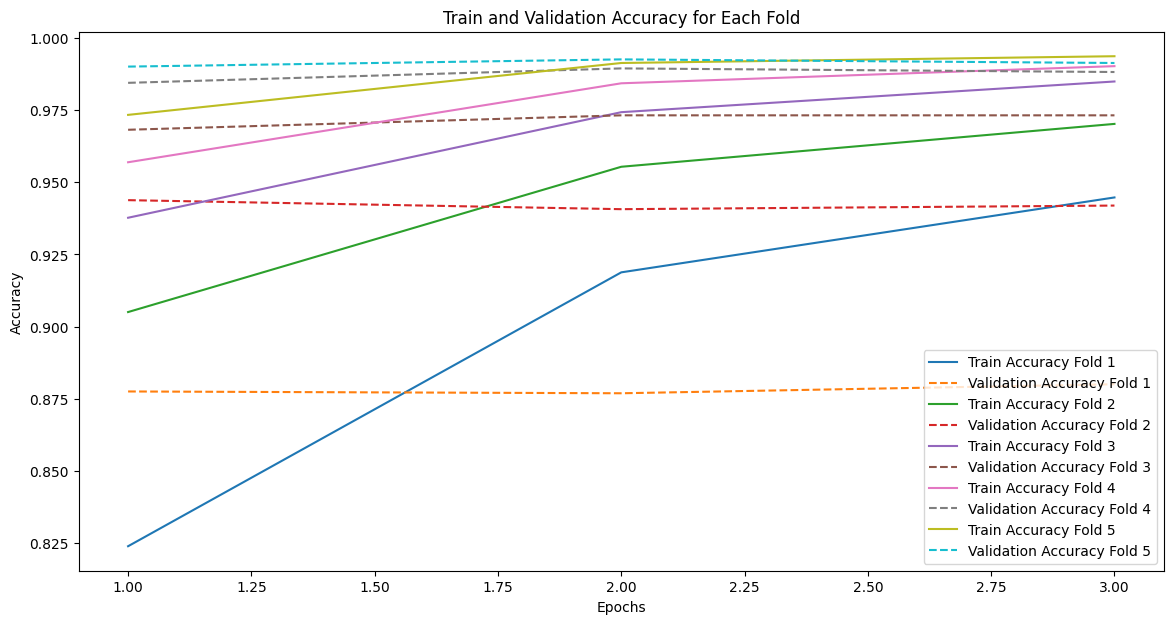

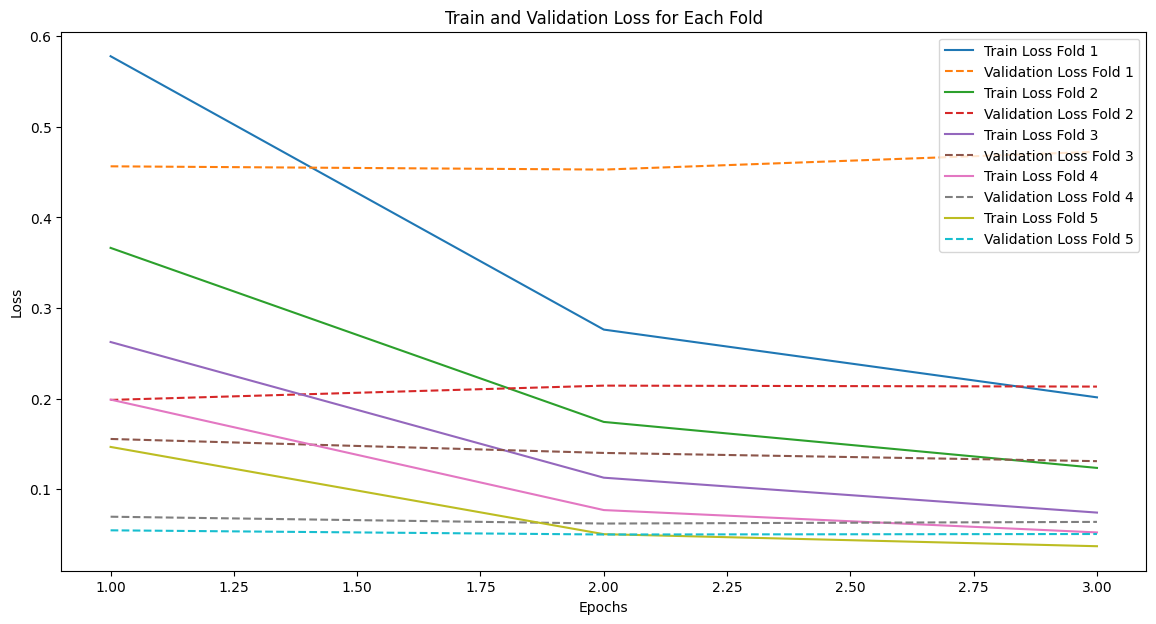

In [ ]:
import matplotlib.pyplot as plt

# Extract data for visualization
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for i, history in enumerate(results):
    train_accuracies.append(history['train_acc'])
    val_accuracies.append(history['val_acc'])
    train_losses.append(history['train_loss'])
    val_losses.append(history['val_loss'])

# Plot train and validation accuracy for each fold
plt.figure(figsize=(14, 7))
for i in range(len(train_accuracies)):
    plt.plot(range(1, EPOCHS + 1), train_accuracies[i], label=f'Train Accuracy Fold {i+1}')
    plt.plot(range(1, EPOCHS + 1), val_accuracies[i], label=f'Validation Accuracy Fold {i+1}', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy for Each Fold')
plt.legend()
plt.show()

# Plot train and validation loss for each fold
plt.figure(figsize=(14, 7))
for i in range(len(train_losses)):
    plt.plot(range(1, EPOCHS + 1), train_losses[i], label=f'Train Loss Fold {i+1}')
    plt.plot(range(1, EPOCHS + 1), val_losses[i], label=f'Validation Loss Fold {i+1}', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss for Each Fold')
plt.legend()
plt.show()


# Heat Map

In [ ]:
pip install scikit-learn


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to get predictions and true labels
def get_predictions_and_labels(model, data_loader):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(outputs, dim=1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Load the best model state
best_model = DistilBERTClassifier(distilbert_model, len(label_mapping))
best_model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_state_v2.bin', map_location=device))
best_model.to(device)
best_model.eval()

# Get predictions and true labels for test dataset
predictions, true_labels = get_predictions_and_labels(best_model, val_loader)

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions, normalize='true')

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'val_loader' is not defined

# Evaluation